# Fake News Classification

***Goal:***
- Detect fake news based on Recurrent Neural Networks (RNN) and Long Short Term Memory (LSTM)

***Result:***
- Overall accuracy 1.0 (total number of data 8980)
- f1-score for real news 1.0 (1 of 4684 real news predicted as fake news) and fake news 1.0 (4 of 4296 real news predicted as fake news)

***Table of Content:***

0. Import Libearies and Dataset
1. Perform Exploratory Data Analysis
2. Perform Data Cleaning
3. Visualize Cleaned Up Dataset
4. Prepare The Data by Performing Tokenization and Padding
5. Build and Train The Model
6. Assess Trained Model Performance

Appendix 1. Understand the Theory and Intuition Behind Recurrent Neural Networks and Long Short Term Memory

<img src="PPT/FakeNewsClassification.png" width="1000">

Source: https://www.coursera.org/projects/nlp-fake-news-detector by Ryan Ahmed - Adjunct Professor

### 0. Import Libearies and Dataset

In [1]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly

[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>


In [2]:
# load the data
df_true = pd.read_csv("data/True_news.csv")
df_fake = pd.read_csv("data/Fake_news.csv")

### 1. Perform Exploratory Data Analysis 

In [3]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        1  
1  December 29, 2017        1  
2  December 31, 2017        1  
3  December 30, 2017        1  
4  December 29, 2017        1

In [4]:
df_fake['isfake'] = 0
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       0  
1  December 31, 2017       0  
2  December 30, 2017       0  
3  December 29, 2017       0  
4  December 25, 2017       0

In [5]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        1  
1      December 29, 2017        1  
2      December 31, 2017        1  
3      December 30, 2017        1  
4      December 29, 2017        1  
...                   ...     ...  
44893    January 16, 2016       0  
44894    January 16, 2016       0  
44895    January 15, 2016       0  
44896    January 14, 2016       0  
44897    January 12, 2016       0  

[44898 rows x 5 columns]

In [6]:
df.drop(columns = ['date'], inplace = True)

In [7]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [8]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

### 2. Perform Data Cleaning

In [10]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [11]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [13]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [14]:
# Show original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [15]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [16]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           1  As U.S. budget fight looms, Republicans flip t...   
1           1  U.S. military to accept transgender recruits o...   
2           1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           1  FBI Russia probe helped by Australian diplomat...   
4           1  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       0  McPain: John McCain Furious That Iran Treated ...   
44894       0  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       0  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       0  How to Blow $700 Million: Al Jazeera America F...   
44897       0  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  
0      [budget, fight, looms, republicans, flip, fisc...  
1      [military, accept, transgender, recruits, mond...  
2      [senior, republican, senator, mueller, washing...  
3      [russia, probe, helped, australian, diplomat, ...  
4      [trump, wants, postal, service, charge, amazon...  
...                                                  ...  
44893  [mcpain, john, mccain, furious, iran, treated,...  
44894  [justice, yahoo, settles, mail, privacy, class...  
44895  [sunnistan, allied, safe, zone, plan, territor...  
44896  [blow, million, jazeera, america, finally, cal...  
44897  [navy, sailors, held, iranian, military, signs...  

[44898 rows x 6 columns]

In [17]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [18]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [19]:
len(list_of_words)

9276947

In [20]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [21]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [22]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           1  As U.S. budget fight looms, Republicans flip t...   
1           1  U.S. military to accept transgender recruits o...   
2           1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           1  FBI Russia probe helped by Australian diplomat...   
4           1  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       0  McPain: John McCain Furious That Iran Treated ...   
44894       0  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       0  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       0  How to Blow $700 Million: Al Jazeera America F...   
44897       0  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

### 3. Visualize Cleaned Up Dataset

<AxesSubplot:xlabel='count', ylabel='isfake'>

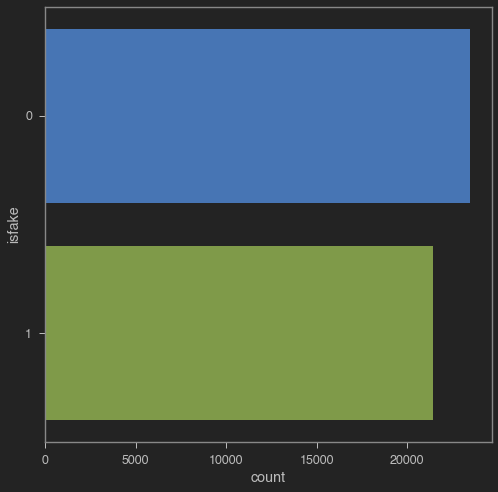

In [23]:
# plot the number of samples per each class
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

<AxesSubplot:xlabel='count', ylabel='subject'>

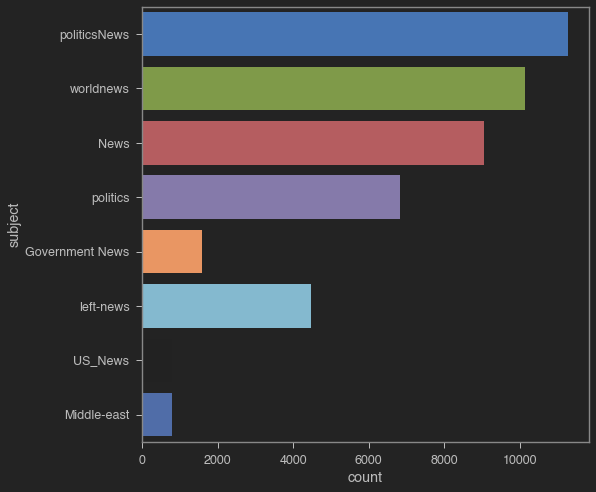

In [24]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

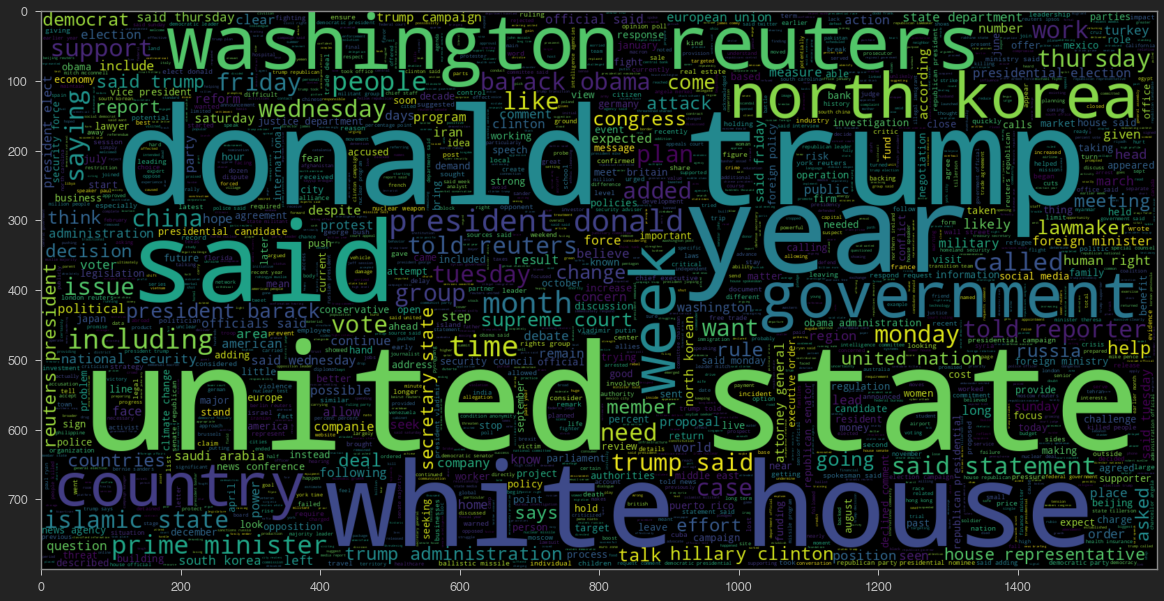

In [25]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

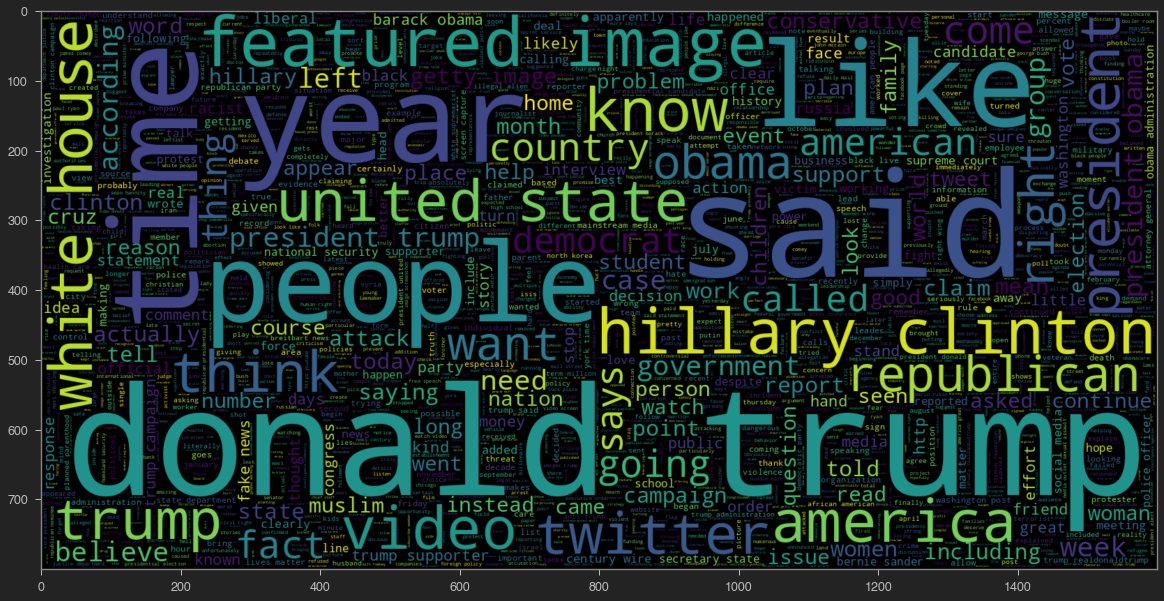

In [26]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [27]:
nltk.word_tokenize(df['clean_joined'][2])       # revert the column 'clean_joined' back to the column 'clean'

['senior',
 'republican',
 'senator',
 'mueller',
 'washington',
 'reuters',
 'special',
 'counsel',
 'investigation',
 'links',
 'russia',
 'president',
 'trump',
 'election',
 'campaign',
 'continue',
 'interference',
 'despite',
 'calls',
 'trump',
 'administration',
 'allies',
 'republican',
 'lawmakers',
 'shut',
 'prominent',
 'republican',
 'senator',
 'said',
 'sunday',
 'lindsey',
 'graham',
 'serves',
 'senate',
 'armed',
 'forces',
 'judiciary',
 'committees',
 'said',
 'department',
 'justice',
 'special',
 'counsel',
 'robert',
 'mueller',
 'needs',
 'carry',
 'russia',
 'investigation',
 'political',
 'interference',
 'investigation',
 'forward',
 'investigation',
 'conducted',
 'political',
 'influence',
 'graham',
 'said',
 'face',
 'nation',
 'news',
 'program',
 'need',
 'mueller',
 'think',
 'right',
 'right',
 'time',
 'question',
 'russia',
 'interfered',
 'election',
 'trump',
 'campaign',
 'links',
 'ordinated',
 'effort',
 'loomed',
 'white',
 'house',
 'trump',

In [28]:
# find out the length of maximum document will be needed to create word embeddings 
maxlen = -1                                # start from maxlen = -1
for doc in df.clean_joined:                # go through each line in df.clean_joined
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):                # if maxlen < len(tokens),  
        maxlen = len(tokens)                # then update the new maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [29]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)    # nbins: number of bin
fig.show()

### 4. Prepare The Data by Performing Tokenization and Padding

In [30]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)   # input x: df.clean_joined, output y: df.isfake, split 20% of data as test set

In [31]:
from nltk import word_tokenize

# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)                             # use fit_on_texts: Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 
train_sequences = tokenizer.texts_to_sequences(x_train)     # use texts_to_sequences: Transforms each texts to a sequence of integers.
test_sequences = tokenizer.texts_to_sequences(x_test)

In [32]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [33]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [34]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  643  2171  7288 12439 11352  5266  5898   993   299   115  1753  4824
  3732  2171   153   202   511  4609  1871 12300   170  3909  1002  4824
  2953  1866   976     4   865  1106  8126   672   902  2412   445    26
    37   613  1057  4509]
The padded encoding for document 2  is :  [ 3516     6   634  1598 11453  3516  2055    83    27     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


### 5. Build and Train The Model

In [35]:
# Sequential Model
model = Sequential()

# embeddidng layer
#model.add(Embedding(total_words, output_dim = 128))
model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

2022-07-25 09:37:17.703615: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 240)         26088960  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              377856    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26,485,377
Trainable params: 26,485,377
Non-trainable params: 0
____________________________________________

In [36]:
y_train = np.asarray(y_train)

In [37]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.2, epochs = 2)

Epoch 1/2
449/449 [==============================] - 99s 217ms/step - loss: 0.0443 - acc: 0.9822 - val_loss: 0.0084 - val_acc: 0.9982
Epoch 2/2
449/449 [==============================] - 97s 217ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0058 - val_acc: 0.9987


### 6. Assess Trained Model Performance

In [38]:
# make prediction
pred = model.predict(padded_test)

In [39]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [40]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9994432071269488


In [41]:
prediction

[0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


<AxesSubplot:>

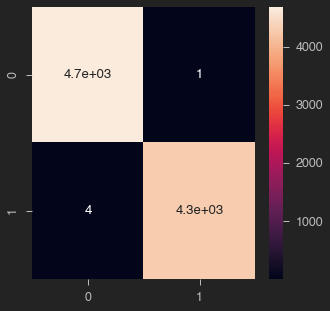

In [42]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True)

In [47]:
# category dict
category = { 0: 'Real News', 1 : "Fake News"}

In [45]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4684
           1       1.00      1.00      1.00      4296

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Appendix 1. Understand the Theory and Intuition Behind Recurrent Neural Networks and Long Short Term Memory
<img src="PPT/FakeNewsClassification_1.png" width="1000">
<img src="PPT/FakeNewsClassification_2.png" width="1000">
<img src="PPT/FakeNewsClassification_3.png" width="1000">
<img src="PPT/FakeNewsClassification_4.png" width="1000">
<img src="PPT/FakeNewsClassification_5.png" width="1000">
<img src="PPT/FakeNewsClassification_6.png" width="1000">
<img src="PPT/FakeNewsClassification_7.png" width="1000">
<img src="PPT/FakeNewsClassification_8.png" width="1000">
<img src="PPT/FakeNewsClassification_9.png" width="1000">
<img src="PPT/FakeNewsClassification_10.png" width="1000">
<img src="PPT/FakeNewsClassification_11.png" width="1000">
<img src="PPT/FakeNewsClassification_12.png" width="1000">
<img src="PPT/FakeNewsClassification_13.png" width="1000">

Source: https://www.coursera.org/projects/nlp-fake-news-detector by Ryan Ahmed - Adjunct Professor

***End of Page***